In [661]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, make_scorer
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import chi2, t, f, norm
from scipy.special import binom

sns.set(font_scale=1)

import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import roc_curve, auc

def plot_roc_auc(ps, ys, labels):
    plt.figure(figsize=(12, 8), dpi=100)
    
    lw = 2
    for p, y, label in zip(ps, ys, labels):
        fpr, tpr, _ = roc_curve(y, p)
        plt.step(fpr, tpr, alpha=1.,  label=label + ', ROC-AUC={}'.format(auc(fpr, tpr)))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return 

# 1. Problem statement

Во-первых, сделаем игрушечную проблему для которой мы можем посчитать идеальный скор с помощью оптимального байесовского классификатора.

In [662]:
class ClassificationProblem:
    def __init__(self, p=0.9, dim=100, diff_coef=1., random_seed=1337):
        self._p = p
        self._dim = dim
        distrs = [stats.norm(), stats.cauchy(), stats.skewnorm(1.)]
        np.random.seed(random_seed)
        self._class_one_distr = np.random.choice(distrs, size=dim, replace=True)
        m = np.random.randn(dim, dim)
        m = m.dot(m) + np.eye(dim)
        self._class_one_mixing_matrix = m
        self._class_one_inv_mixing_matrix = np.linalg.inv(self._class_one_mixing_matrix)
        
        self._class_two_distr = self._class_one_distr
        m = np.random.randn(dim, dim) * diff_coef
        m = m.dot(m)
        self._class_two_mixing_matrix = self._class_one_mixing_matrix + m
        self._class_two_inv_mixing_matrix = np.linalg.inv(self._class_two_mixing_matrix)
        np.random.seed()
        
    @staticmethod
    def generate_by_distr(distrs, mixing, samples=1000):
        X = []
        for dist in distrs:
            X.append(dist.rvs(samples))
        X = np.array(X).T
        X = X.dot(mixing)
        return X
    
    @staticmethod
    def log_pdf_by_distr(X, distrs, inv_mixing):
        X = X.dot(inv_mixing)
        X_log_pdf = []
        for i, dist in enumerate(distrs):
            X_log_pdf.append(dist.logpdf(X[:, i]))
        X_log_pdf = np.array(X_log_pdf).T
        return X_log_pdf
        
    def generate_class(self, cl, samples=1000):
        if cl == 0:
            X = self.generate_by_distr(self._class_one_distr, self._class_one_mixing_matrix, samples=samples)
        elif cl == 1:
            X = self.generate_by_distr(self._class_two_distr, self._class_two_mixing_matrix, samples=samples)
        return X
    
    def generate(self, samples=1000):
        p = stats.bernoulli(self._p).rvs(samples)
        l = p.sum()
        X_0 = self.generate_class(0, samples=l)
        X_1 = self.generate_class(1, samples=samples - l)
        X = np.concatenate([X_0, X_1], axis=0)
        y = np.concatenate([np.zeros(l), np.ones(samples - l)])
        idx = np.arange(len(y))
        np.random.shuffle(idx)
        return X[idx], y[idx]

    def predict_proba(self, X):
        log_pdf_0 = self.log_pdf_cond(X, 0).sum(axis=1)
        log_pdf_1 = self.log_pdf_cond(X, 1).sum(axis=1)
        p = log_pdf_1 + np.log(self._p) - np.logaddexp(log_pdf_0 + np.log(1 - self._p), log_pdf_1 + np.log(self._p))
        return np.exp(p)
    
    def log_pdf_cond(self, X, cl):
        if cl == 0:
            return self.log_pdf_by_distr(X, self._class_one_distr, self._class_one_inv_mixing_matrix)
        if cl == 1:
            return self.log_pdf_by_distr(X, self._class_two_distr, self._class_two_inv_mixing_matrix)

### Сгенерируем данные для обучения и данные для расчёта оптимального качества модели

In [663]:
classification_problem = ClassificationProblem(dim=20, p=0.5, diff_coef=.6)
X, y = classification_problem.generate(samples=1000)
X_test_big, y_test_big = classification_problem.generate(samples=100000)

Идеальный теоретически достижимый ROC-AUC:

In [664]:
p_test_big = classification_problem.predict_proba(X_test_big)
ideal_score_estimate = roc_auc_score(y_test_big, p_test_big)
print(ideal_score_estimate)

0.9999997179985596


ROC-AUC случайного леса с дефолтными параметрами:

In [665]:
clf = ExtraTreesClassifier()
clf.fit(X, y)
p_test_predict_big = clf.predict_proba(X_test_big)[:, 1]
roc_auc_score(y_test_big, p_test_predict_big)

0.7514249249779469

ROC-кривые для двух классификаторов: идеального и не очень.

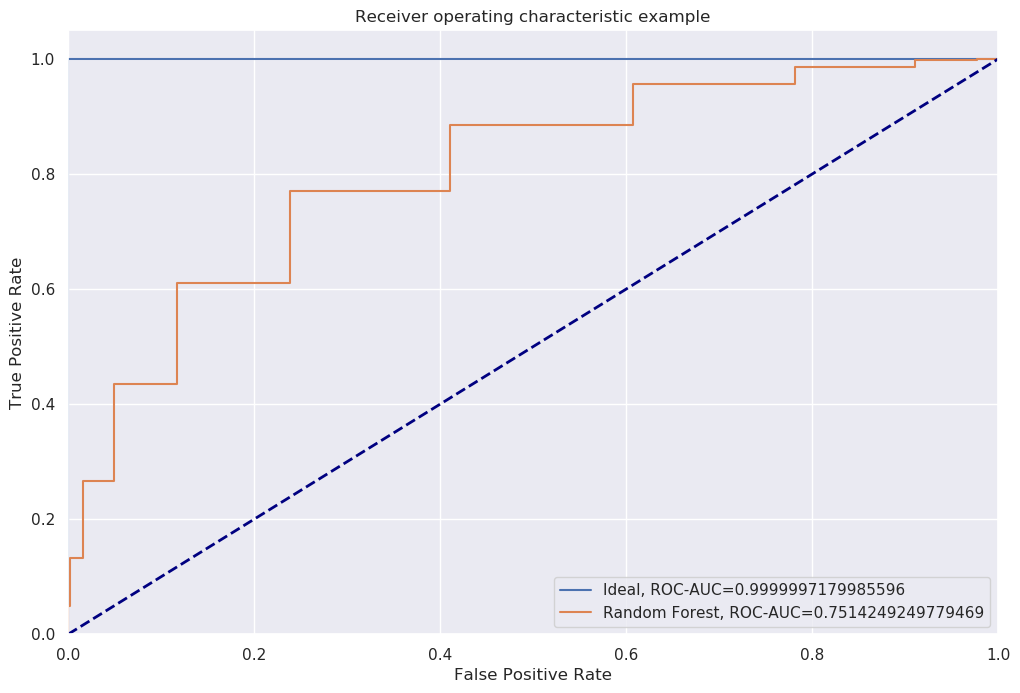

In [666]:
plot_roc_auc([p_test_big, p_test_predict_big], [y_test_big, y_test_big], ['Ideal', 'Random Forest'])

# 2. Metric estimation and confidence intervals

  * QxK CV
  * Leave-one-out CV
  * Vanilla bootstrap
  * out-of-bag bootstrap
  * 0.632-bootstrap
  * $\omega$-bootstrap

### QxK Cross-Validation

In [667]:
def qk_cv(clf, X, y, q=5, k=5, metric=roc_auc_score, random_state=1337):
    metric = make_scorer(metric, needs_proba=False)
    metric_vals = cross_val_score(clf, X, y, 
                                  cv=RepeatedStratifiedKFold(n_splits=k, n_repeats=q, random_state=random_state), 
                                  n_jobs=-1, scoring=metric)
    std = np.std(np.array(metric_vals).reshape(-1, k), axis=1) / np.sqrt(k - 1)
    return metric_vals, std

### Leave-one-out CV

In [668]:
def loo_cv(clf, X, y, metric=roc_auc_score):
    metric = make_scorer(metric, needs_proba=False)
    metric_vals = cross_val_score(clf, X, y, 
                                  cv=LeaveOneOut(), n_jobs=-1, scoring=metric)
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Leave-pair-out CV

http://proceedings.mlr.press/v8/airola10a/airola10a.pdf



In [669]:
import itertools
class LeavePairOut:
    def __init__(self, random_state=1337, **kwargs):
        self._random_state = random_state
    
    def get_n_splits(self, X, y, groups=None):
        assert len(X) == len(y)
        n = len(X)
        idx = np.arange(n)
        idx_minus = idx[y == 0]
        idx_plus = idx[y == 1]
        idx = set(idx)
        test_indices = list(itertools.product(idx_minus, idx_plus))
        return len(test_indices)
        
    def split(self, X, y, groups=None):
        assert len(X) == len(y)
        n = len(X)
        idx = np.arange(n)
        idx_minus = idx[y == 0]
        idx_plus = idx[y == 1]
        idx = set(idx)
        test_indices = list(itertools.product(idx_minus, idx_plus))
        for test_index in tqdm(test_indices):
            train_index = np.array(list(idx - set(test_index)))
            yield train_index, np.array(test_index)
            
def lpo_cv(clf, X, y, metric=roc_auc_score):
    metric = make_scorer(metric, needs_proba=False)
    print(LeavePairOut().get_n_splits(X, y))
    metric_vals = cross_val_score(clf, X, y, 
                                  cv=LeavePairOut(), n_jobs=-1, scoring=metric)
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Bootstrap

In [670]:
def bootstrap_vanilla(clf, X, y, B=200, metric=roc_auc_score):
    idx = np.arange(len(X))
    B_idx = np.random.choice(idx, size=(B, len(X)))
    metric_vals = []
    for b_idx in tqdm(B_idx):
        X_b = X[b_idx]
        y_b = y[b_idx]
        clf.fit(X_b, y_b)
        y_b_pred = clf.predict_proba(X_b)[:, 1]
        metric_vals.append(metric(y_b, y_b_pred))
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Bootstrap Out-Of-Bag

In [671]:
def bootstrap_oob(clf, X, y, B=200, metric=roc_auc_score):
    idx = np.arange(len(X))
    B_idx = np.random.choice(idx, size=(B, len(X)))
    metric_vals = []
    for b_idx in tqdm(B_idx):
        X_b = X[b_idx]
        y_b = y[b_idx]
        clf.fit(X_b, y_b)
        boo_idx = list(set(idx) - set(b_idx))
        y_b_pred = clf.predict_proba(X[boo_idx])[:, 1]
        metric_vals.append(metric(y[boo_idx], y_b_pred))
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Bootstrap-0.632

In [672]:
def bootstrap_632(clf, X, y, B=200, metric=roc_auc_score):
    idx = np.arange(len(X))
    B_idx = np.random.choice(idx, size=(B, len(X)))
    metric_vals = []
    for b_idx in tqdm(B_idx):
        X_b = X[b_idx]
        y_b = y[b_idx]
        clf.fit(X_b, y_b)
        y_b_pred = clf.predict_proba(X_b)[:, 1]
        optimistic_metric = metric(y_b, y_b_pred==1.)
        boo_idx = list(set(idx) - set(b_idx))
        y_b_pred = clf.predict_proba(X[boo_idx])[:, 1]
        pessimistic_metric = metric(y[boo_idx], y_b_pred)
        metric_vals.append(0.632 * pessimistic_metric + 0.368 * optimistic_metric)
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Bootstrap-$\omega$

In [673]:
def bootstrap_omega(clf, X, y, B=200, metric=roc_auc_score):
    idx = np.arange(len(X))
    B_idx = np.random.choice(idx, size=(B, len(X)))
    metric_vals = []
    for b_idx in tqdm(B_idx):
        X_b = X[b_idx]
        y_b = y[b_idx]
        clf.fit(X_b, y_b)
        y_b_pred = clf.predict_proba(X_b)[:, 1]
        p_1 = sum(y_b) / len(y_b)
        q_1 = sum(y_b_pred==1.) / len(y_b_pred)
        
        optimistic_metric = metric(y_b, y_b_pred > 0.5)
        boo_idx = list(set(idx) - set(b_idx))
        y_b_pred = clf.predict_proba(X[boo_idx])[:, 1]
        pessimistic_metric = metric(y[boo_idx], y_b_pred > 0.5)
        

        gamma = (1 - p_1) * q_1 + p_1 * (1 - q_1)
        R = - (pessimistic_metric - optimistic_metric) / (gamma - (1 - pessimistic_metric))
        omega = 0.632 / (1 - 0.368 * R)
        omega = np.clip(omega, 0, 1)
        metric_vals.append(omega * pessimistic_metric + optimistic_metric * (1 - omega))

    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Считаем валидационные скоры для всех моделей

In [674]:
vals_cv_40_5, std_cv_40_5 = qk_cv(clf, X, y, q=40, k=5)
vals_cv_40_10, std_cv_40_10 = qk_cv(clf, X, y, q=40, k=10)
vals_cv_40_15, std_cv_40_15 = qk_cv(clf, X, y, q=40, k=15)
vals_cv_40_20, std_cv_40_20 = qk_cv(clf, X, y, q=40, k=20)
vals_cv_40_30, std_cv_40_30 = qk_cv(clf, X, y, q=40, k=30)
vals_cv_40_40, std_cv_40_40 = qk_cv(clf, X, y, q=40, k=40)
vals_cv_40_80, std_cv_40_80 = qk_cv(clf, X, y, q=40, k=80)
vals_cv_40_160, std_cv_40_160 = qk_cv(clf, X, y, q=40, k=160)
vals_cv_40_320, std_cv_40_320 = qk_cv(clf, X, y, q=40, k=320)
vals_lpocv, std_lpocv = lpo_cv(clf, X, y)

vals_b_vanilla, std_b_vanilla = bootstrap_vanilla(clf, X, y)
vals_b_632, std_b_632 = bootstrap_632(clf, X, y)
vals_b_oob, std_cvs_b_oob = bootstrap_oob(clf, X, y)
vals_b_omega, std_b_omega = bootstrap_omega(clf, X, y)

249271


In [675]:
cross_vals = [
    vals_cv_40_5, vals_cv_40_10, vals_cv_40_15, vals_cv_40_20, 
    vals_cv_40_30, vals_cv_40_40, vals_cv_40_80, vals_cv_40_160, 
    vals_cv_40_320, vals_lpocv, vals_b_vanilla, vals_b_632, vals_b_oob, vals_b_omega
]

cross_std = [
    std_cv_40_5, std_cv_40_10, std_cv_40_15, std_cv_40_20, std_cv_40_30,
    std_cv_40_40, std_cv_40_80, std_cv_40_160, std_cv_40_320, std_lpocv,  
    std_b_vanilla, std_b_632, std_cvs_b_oob, std_b_omega
]

labels = [
    "20x5 CV", "20x10 CV", "20x15 CV", "20x20 CV", "20x30 CV", 
    "20x40 CV", "20x80 CV", "20x160 CV", "20x320 CV", "LPO-CV",
    "Bootstrap",  "Bootstrap 0.632", "Bootstrap Out-Of-Bag", "Bootstrap Omega"
]

assert len(cross_vals) == len(cross_std) == len(labels)

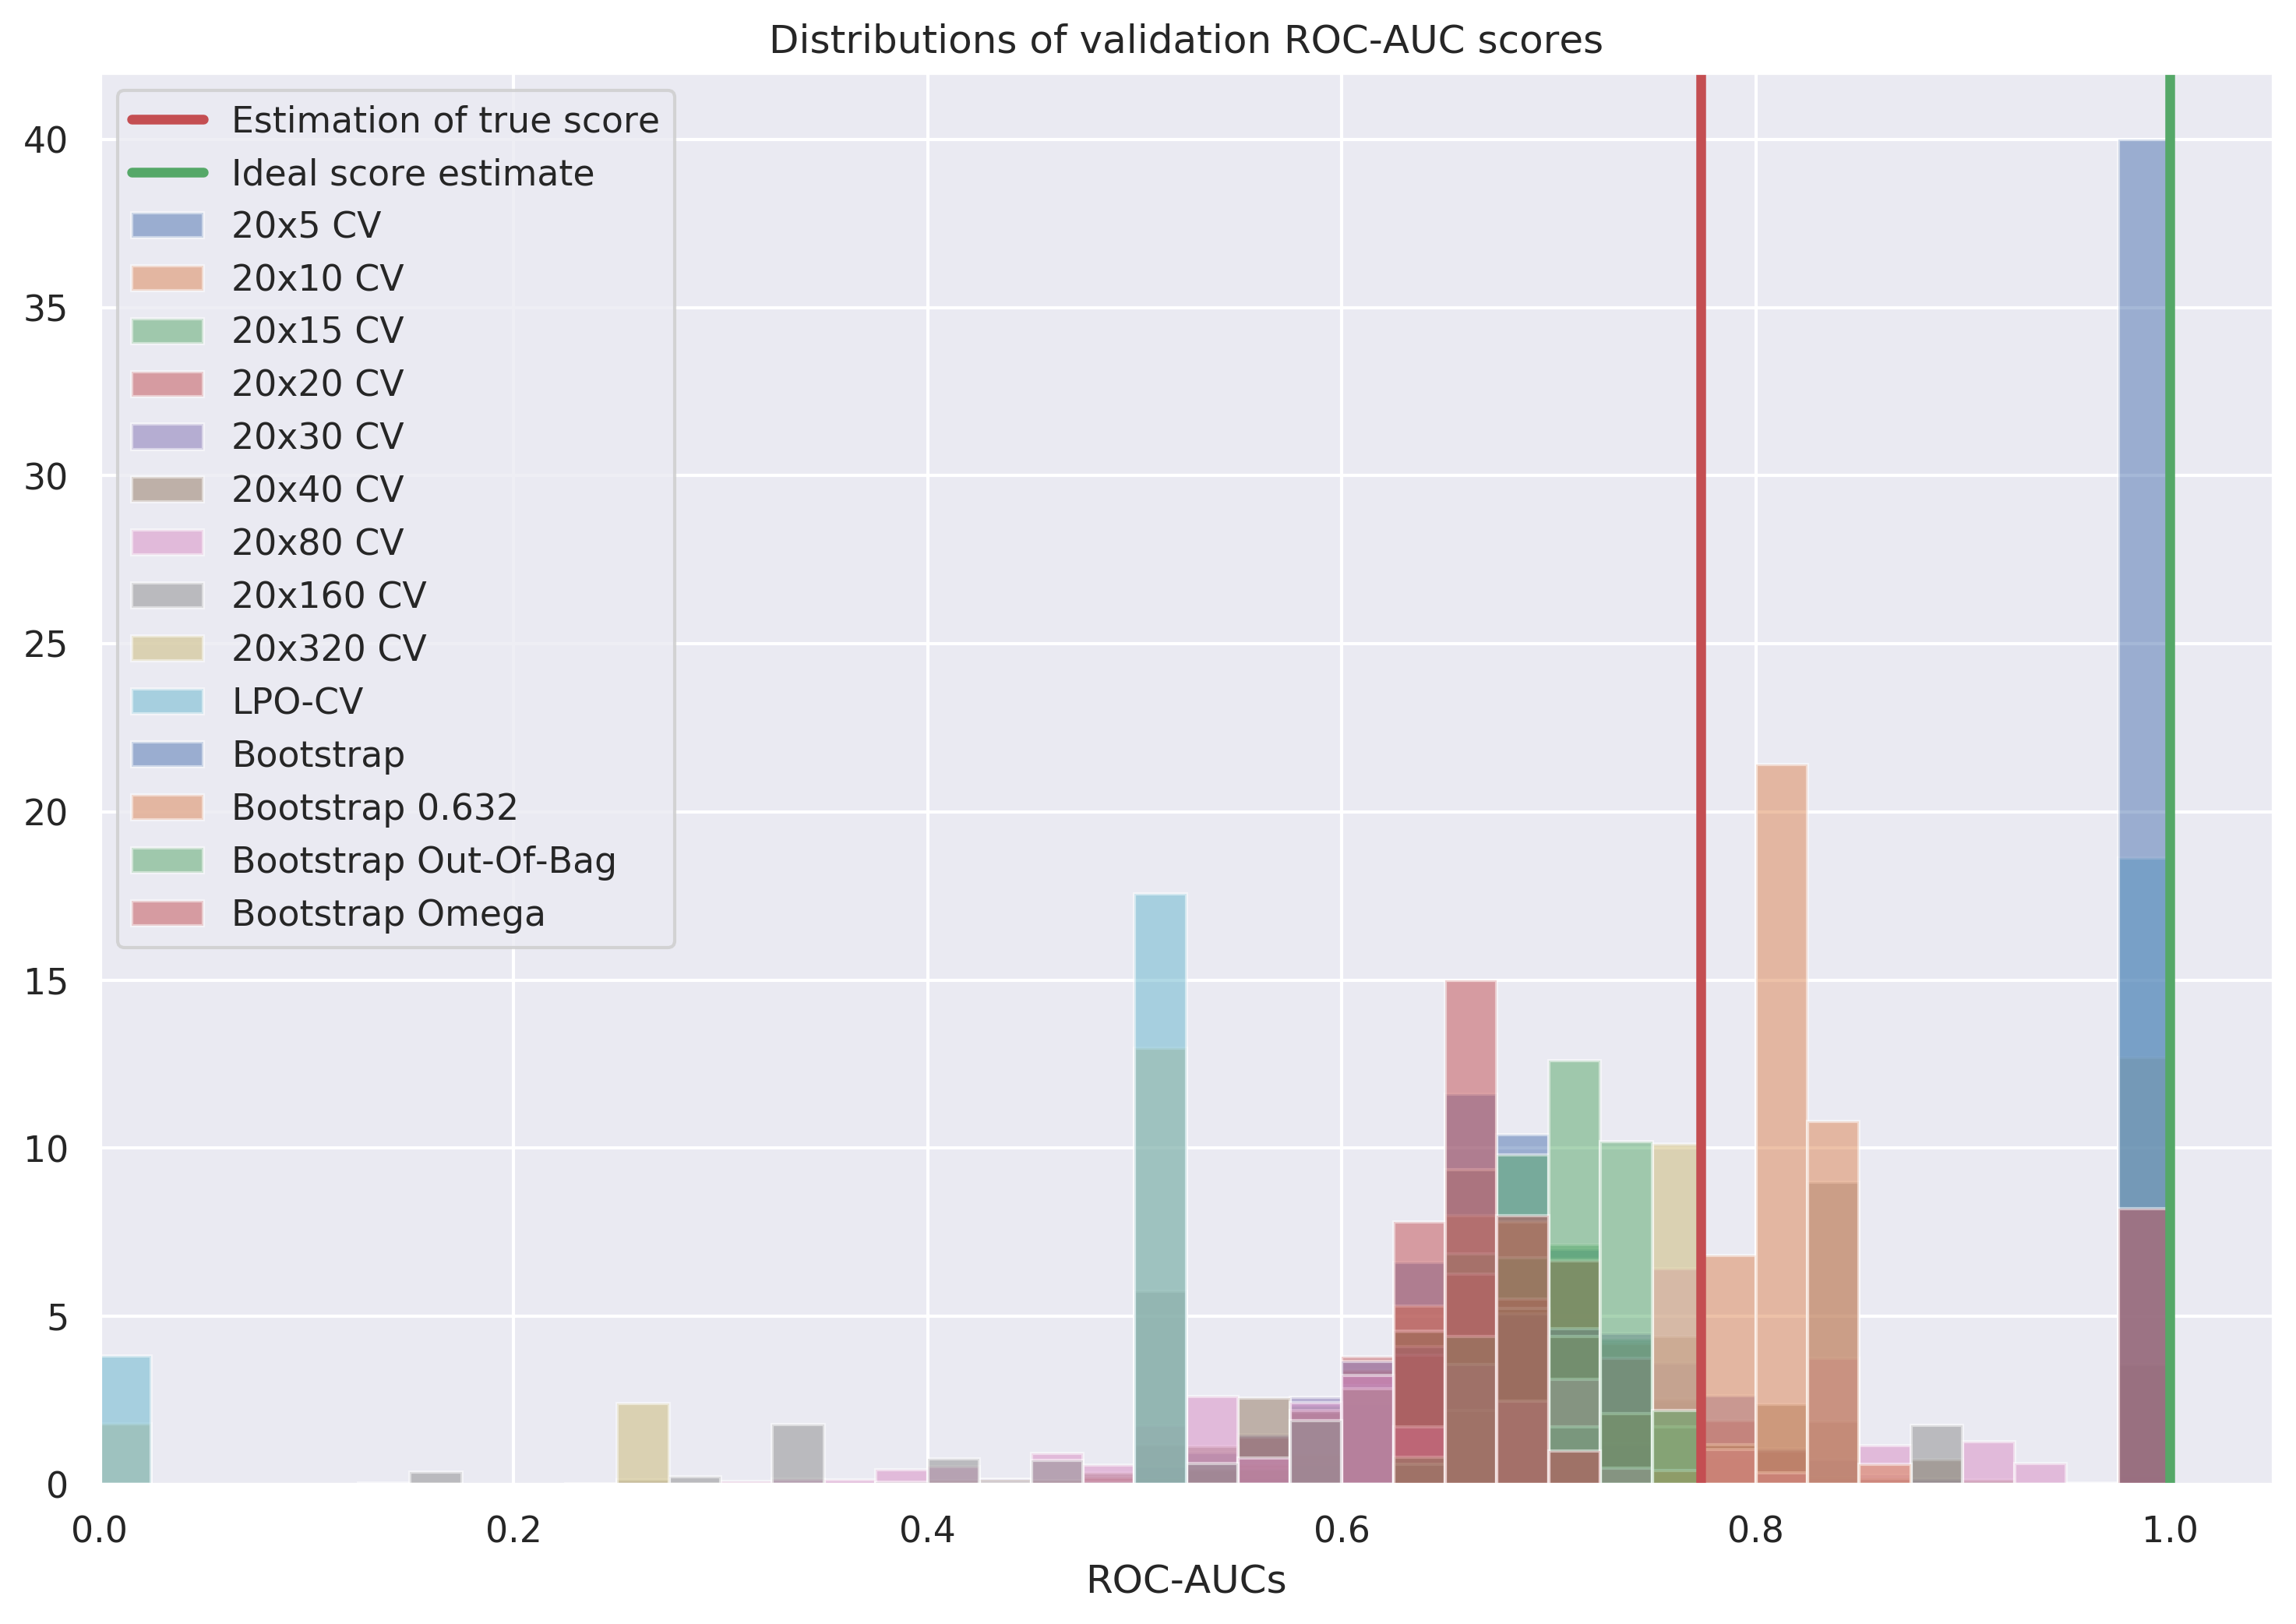

In [676]:
plt.figure(figsize=(12, 8), dpi=300)
plt.title('Distributions of validation ROC-AUC scores')
for vals, label in zip(cross_vals, labels):
    plt.hist(vals, density=True, bins=40, label=label, alpha=0.5, range=(0., 1.))

plt.xlabel('ROC-AUCs')
plt.xlim(0.0, 1.05)
plt.axvline(true_score_estimate, lw=3, c='r', label="Estimation of true score")
plt.axvline(ideal_score_estimate, lw=3, c='g', label="Ideal score estimate")
plt.legend()
plt.show()

## Bias and variance of all methods

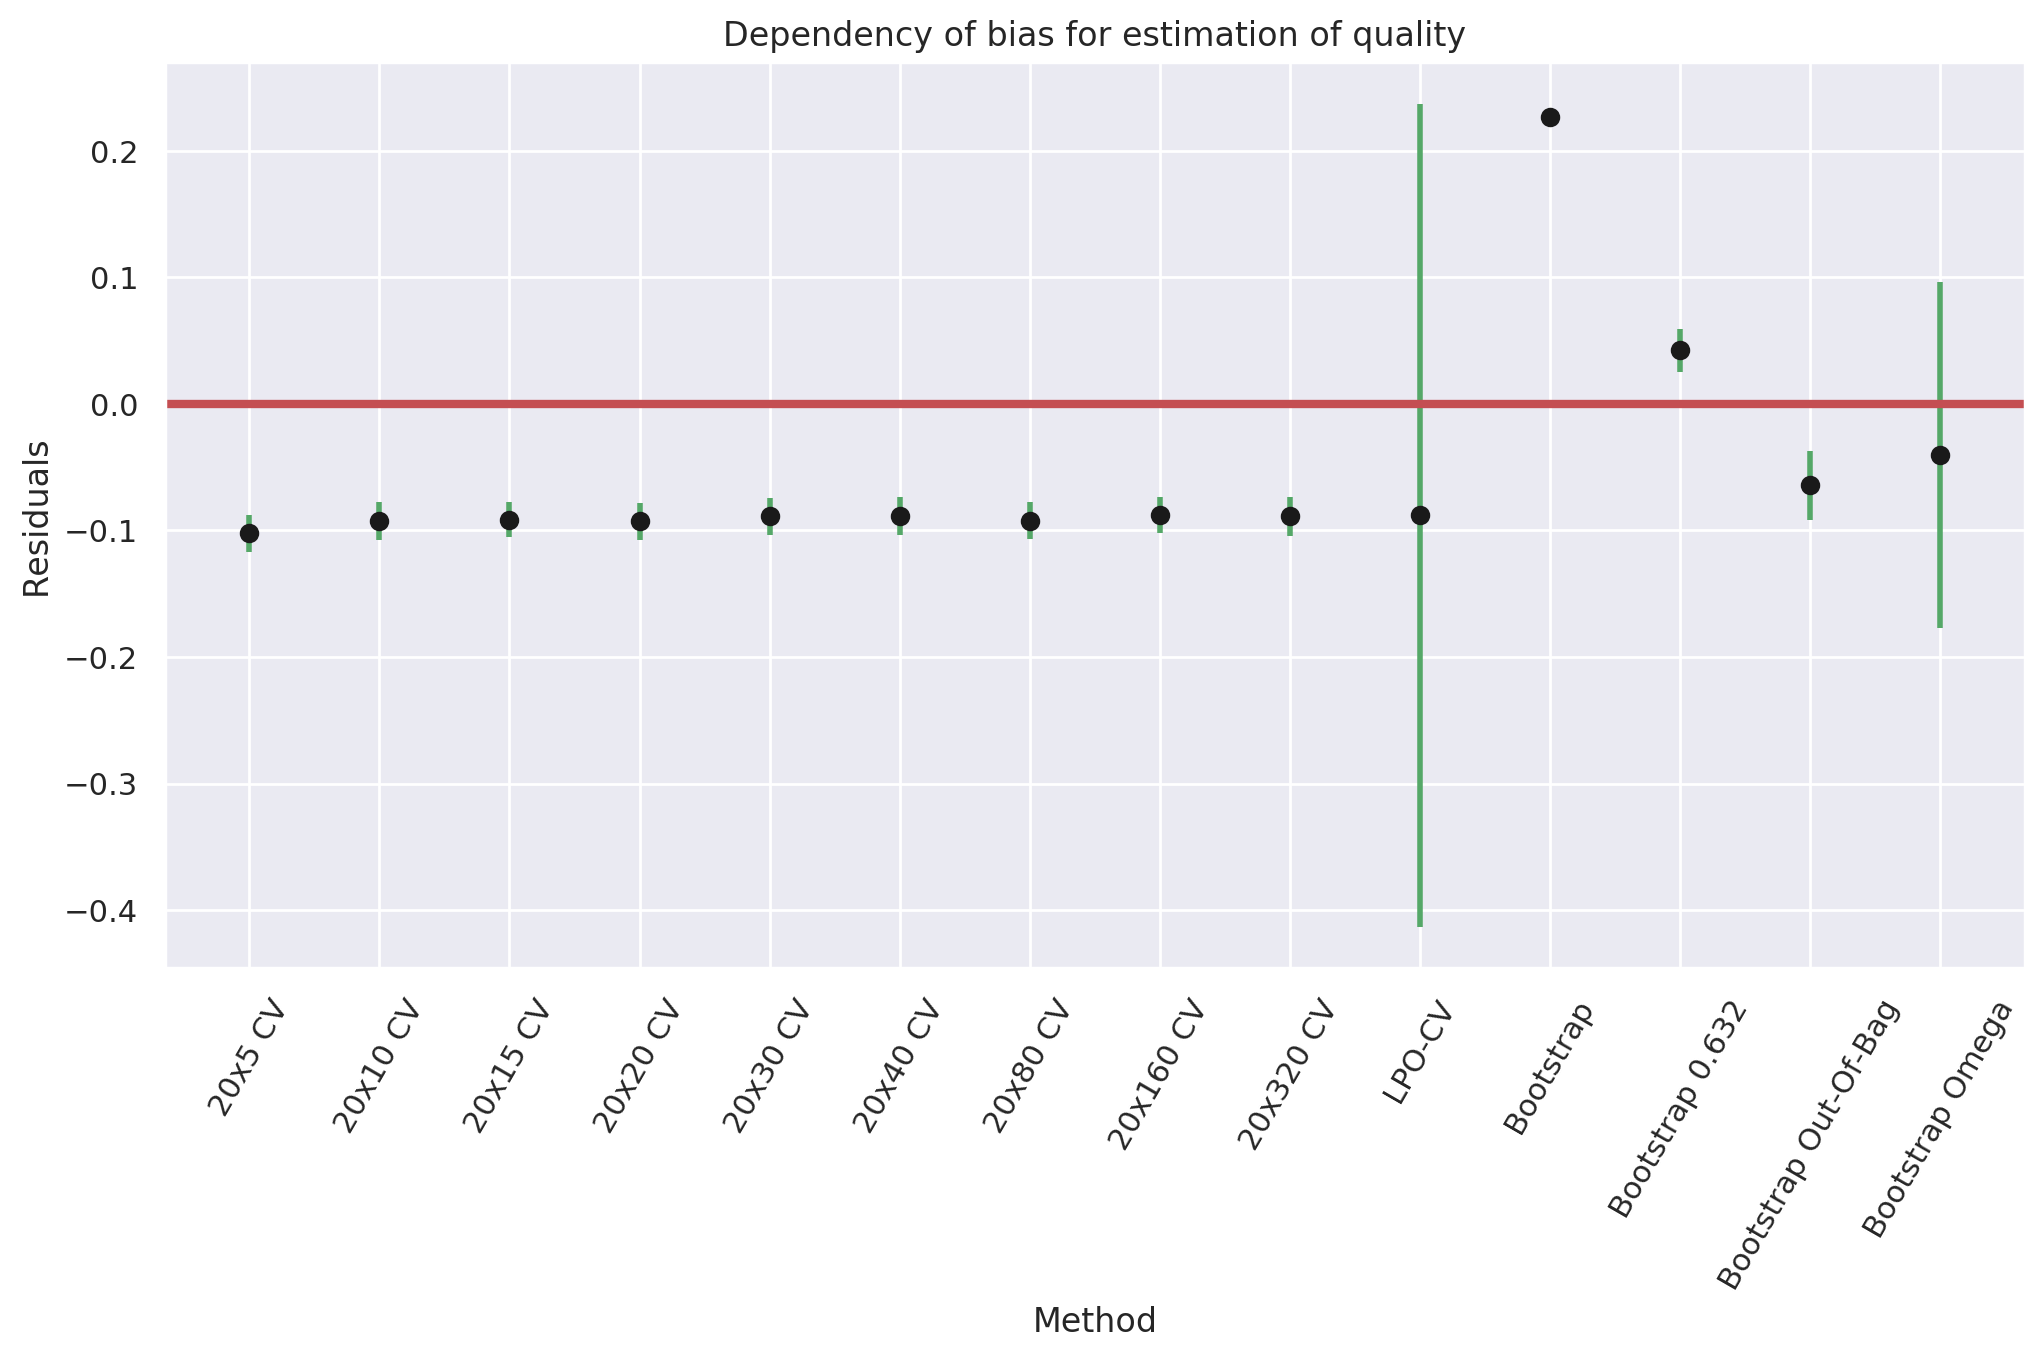

In [677]:
plt.figure(figsize=(12, 6), dpi=200)
plt.title("Dependency of bias for estimation of quality")
plt.axhline(0., lw=3, c='r', label="Estimation of true score")

x = np.arange(len(cross_vals))

plt.errorbar(x, 
             np.array([np.mean(cv) for cv in cross_vals]) - true_score_estimate, 
             [np.mean(std) for std in cross_std], 
             fmt='ok', 
             lw=2, alpha=1., ecolor='g')

plt.xticks(x, labels, rotation=60)
plt.ylabel('Residuals')
plt.xlabel('Method')
plt.show()

### Coverage

В принципе, видно что coverage будет плохой почти для всех моделей из-за очень большого смещения оценки. Если смотреть по единичной реализации, то лучшее качество показывает bootstrap out-of-bag.

# 3. Algorithm comparison

  * McNemar test
  * Fisher test
  * Resampled paired t-test
  * k-fold CV paired t-test
  * Dietterich's 5x2-Fold CV paired t-test

In [685]:
algorithm_1 = KNeighborsClassifier()
algorithm_2 = ExtraTreesClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [686]:
algorithm_1.fit(X_train, y_train);
algorithm_2.fit(X_train, y_train);

In [687]:
y_proba_1 = algorithm_1.predict_proba(X_test)[:, 1]
y_proba_2 = algorithm_2.predict_proba(X_test)[:, 1]

In [688]:
roc_auc_score(y_test, y_proba_1), roc_auc_score(y_test, y_proba_2)

(0.6871832702546667, 0.7904612226570017)

### DeLong test

Этот метод учитывает корреляции между положительным и отрицательными классами.

In [689]:
from compare_auc_delong_xu import delong_roc_variance

In [690]:
delong_mean_1, delong_var_1 = delong_roc_variance(y_test, y_proba_1)
delong_mean_2, delong_var_2 = delong_roc_variance(y_test, y_proba_2)

In [691]:
z_statistic = np.abs(delong_mean_1 - delong_mean_2) / np.sqrt(delong_var_1**2 + delong_var_2**2)

In [692]:
1 - norm.cdf(np.abs(z_statistic))

0.0

#### Расчёт ошибки 1 рода

In [698]:
N = 1000
count = 0
for _ in tqdm(range(N)):
    y_proba_1 = ExtraTreesClassifier().fit(X_train, y_train).predict_proba(X_test)[:, 1]
    y_proba_2 = ExtraTreesClassifier().fit(X_train, y_train).predict_proba(X_test)[:, 1]
    delong_mean_1, delong_var_1 = delong_roc_variance(y_test, y_proba_1)
    delong_mean_2, delong_var_2 = delong_roc_variance(y_test, y_proba_2)
    roc_auc_1, roc_auc_2 = roc_auc_score(y_test, y_proba_1), roc_auc_score(y_test, y_proba_2)
    z_statistic = np.abs(roc_auc_1 - roc_auc_2) / np.sqrt(delong_var_1 + delong_var_2)
    
    count += (1 - norm.cdf(np.abs(z_statistic)) < 0.05)
print(count / N)

0.042


### McNemar тест или $\chi^2$-метод

In [700]:
A = (y_proba_1[y_test == 1] * y_proba_2[y_test == 1]).sum() + ((1 - y_proba_1[y_test == 0]) * (1 - y_proba_2[y_test == 0])).sum()
B = (y_proba_1[y_test == 1] * (1 - y_proba_2[y_test == 1])).sum() + ((1 - y_proba_1[y_test == 0]) * (y_proba_2[y_test == 0])).sum()
C = ((1 - y_proba_1[y_test == 1]) * y_proba_2[y_test == 1]).sum() + ((y_proba_1[y_test == 0]) * (1 - y_proba_2[y_test == 0])).sum()
D = ((1 - y_proba_1[y_test == 1]) * (1 - y_proba_2[y_test == 1])).sum() + ((y_proba_1[y_test == 0]) * (y_proba_2[y_test == 0])).sum()

In [701]:
B, C

(53.94, 55.84)

In [702]:
statistic = (np.abs(B - C) - 1)**2 / (B + C)
p_value = 1 - chi2.cdf(statistic, df=1)

print('Chi2 test p-value: {:.4f}'.format(p_value))

Chi2 test p-value: 0.9315


In [703]:
threshold = 0.5

A = ((y_proba_1 > threshold) & (y_test == 1) & (y_proba_2 > threshold)).sum() + ((y_proba_1 < threshold) & (y_test == 0) & (y_proba_2 < threshold)).sum()
B = ((y_proba_1 > threshold) & (y_test == 1) & (y_proba_2 < threshold)).sum() + ((y_proba_1 < threshold) & (y_test == 0) & (y_proba_2 > threshold)).sum()
C = ((y_proba_1 < threshold) & (y_test == 1) & (y_proba_2 > threshold)).sum() + ((y_proba_1 > threshold) & (y_test == 0) & (y_proba_2 < threshold)).sum()
D = ((y_proba_1 < threshold) & (y_test == 1) & (y_proba_2 < threshold)).sum() + ((y_proba_1 > threshold) & (y_test == 0) & (y_proba_2 > threshold)).sum()

In [704]:
B, C

(13, 21)

In [705]:
statistic = (np.abs(B - C) - 1)**2 / (B + C)
p_value = 1 - chi2.cdf(statistic, df=1)

print('Chi2 test p-value: {:.4f}'.format(p_value))

Chi2 test p-value: 0.2299


#### Расчёт ошибки 1 рода

In [706]:
threshold = 0.5
N = 1000
count = 0
for _ in tqdm(range(N)):
    y_proba_1 = ExtraTreesClassifier().fit(X_train, y_train).predict_proba(X_test)[:, 1]
    y_proba_2 = ExtraTreesClassifier().fit(X_train, y_train).predict_proba(X_test)[:, 1]    
    A = ((y_proba_1 > threshold) & (y_test == 1) & (y_proba_2 > threshold)).sum() + ((y_proba_1 < threshold) & (y_test == 0) & (y_proba_2 < threshold)).sum()
    B = ((y_proba_1 > threshold) & (y_test == 1) & (y_proba_2 < threshold)).sum() + ((y_proba_1 < threshold) & (y_test == 0) & (y_proba_2 > threshold)).sum()
    C = ((y_proba_1 < threshold) & (y_test == 1) & (y_proba_2 > threshold)).sum() + ((y_proba_1 > threshold) & (y_test == 0) & (y_proba_2 < threshold)).sum()
    D = ((y_proba_1 < threshold) & (y_test == 1) & (y_proba_2 < threshold)).sum() + ((y_proba_1 > threshold) & (y_test == 0) & (y_proba_2 > threshold)).sum()
    statistic = (np.abs(B - C) - 1)**2 / (B + C)
    count += (1 - chi2.cdf(statistic, df=1)) < 0.05
print(count / N)

0.044


### Точный тест через биномиальное разложение 

Цитата с Вики:


Точный тест(англ. exact test) — такой статистический критерий, при котором в ходе проверки гипотезы вероятность ошибки первого рода всегда равна уровню значимости. Соответственно, можно рассчитать точное p-значение (англ. exact p-value).



In [707]:
p_value = 0.
for i in np.arange(max(B, C), B + C + 1):
    p_value += 2 * binom(B + C, i) * (0.5)**(B + C)
print('p-value: {:.4f}'.format(p_value))

p-value: 0.2682


### k-fold CV paired t-test

In [732]:
k = 5
xx, _ = qk_cv(algorithm_1, X, y, q=1, k=k, random_state=1337)

In [733]:
yy, _ = qk_cv(algorithm_2, X, y, q=1, k=k, random_state=1337)

In [734]:
diff = xx - yy
t_statistic = diff.mean() * np.sqrt(k) / (np.sqrt(((diff - diff.mean())**2).sum() / (k - 1)))

In [735]:
t_statistic

-6.011942674471795

In [736]:
1 - t.cdf(np.abs(t_statistic), df=k - 1)

0.0019271694571272313

#### Расчёт ошибки 1 рода

In [ ]:
k=5
N = 1000
count = 0
for _ in tqdm(range(N)):
    xx, _ = qk_cv(ExtraTreesClassifier(), X, y, q=1, k=k, random_state=1337)
    yy, _ = qk_cv(ExtraTreesClassifier(), X, y, q=1, k=k, random_state=1337)
    diff = xx - yy
    t_statistic = diff.mean() * np.sqrt(k) / (np.sqrt(((diff - diff.mean())**2).sum() / (k - 1)))
    
    count += (1 - t.cdf(np.abs(t_statistic), df=k - 1)) < 0.05
print(count / N)

### Dietterich's 5x2-Fold CV paired t-test

In [ ]:
xx, _ = qk_cv(algorithm_1, X, y, q=5, k=2, random_state=1337)
yy, _ = qk_cv(algorithm_2, X, y, q=5, k=2, random_state=1337)

In [ ]:
roc_auc_A = (xx - yy)[::2]
roc_auc_B = (xx - yy)[1::2]
average = (roc_auc_A + roc_auc_B) / 2

In [ ]:
s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)

In [ ]:
t_statistic = xx[0] / np.sqrt(s2.mean())

In [ ]:
1 - t.cdf(np.abs(t_statistic), df=5)

In [ ]:
k=5
N = 1000
count = 0
for _ in tqdm(range(N)):
    xx, _ = qk_cv(ExtraTreesClassifier(), X, y, q=5, k=2, random_state=1337)
    yy, _ = qk_cv(ExtraTreesClassifier(), X, y, q=5, k=2, random_state=1337)
    roc_auc_A = (xx - yy)[::2]
    roc_auc_B = (xx - yy)[1::2]
    average = (roc_auc_A + roc_auc_B) / 2
    s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)
    t_statistic = xx[0] / np.sqrt(s2.mean())
    count += (1 - t.cdf(np.abs(t_statistic), df=5)) < 0.05
print(count / N)

### Alpaydin’s Combined 5x2 CV F-test

In [ ]:
f_statistic = ((xx**2).sum() + (yy**2).sum()) / (2 * s2.sum())

In [ ]:
1 - f.cdf(np.abs(f_statistic), dfn=10, dfd=5)

In [ ]:
k=5
N = 1000
count = 0
for _ in tqdm(range(N)):
    xx, _ = qk_cv(ExtraTreesClassifier(), X, y, q=2, k=k, random_state=1337)
    yy, _ = qk_cv(ExtraTreesClassifier(), X, y, q=2, k=k, random_state=1337)
    roc_auc_A = (xx - yy)[::2]
    roc_auc_B = (xx - yy)[1::2]
    average = (roc_auc_A + roc_auc_B) / 2
    s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)
    f_statistic = ((xx**2).sum() + (yy**2).sum()) / (2 * s2.sum())
    count += (1 - f.cdf(np.abs(f_statistic), dfn=10, dfd=5)) < 0.05
print(count / N)